In [11]:
%pip install tensorflow
%pip install keras

%pip install matplotlib.pyplot
%pip install seaborn 


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.datasets import fashion_mnist
from keras.layers import InputLayer,Dense,Flatten
from keras import Sequential
from keras.utils import plot_model
from sklearn.metrics import classification_report,confusion_matrix

In [13]:
import pandas as pd
import os

# Dans Docker, le dossier est monté ici :
full_path = "/workspace/DATASET"

# Lecture des fichiers
train_df = pd.read_csv(os.path.join(full_path, "train_labels.csv"))
test_df = pd.read_csv(os.path.join(full_path, "test_labels.csv"))

print("✅ Succès ! Fichiers chargés dans le conteneur.")
print(train_df.head())

# Pour construire le chemin des images plus tard :
# Le chemin sera : /workspace/DATASET/train/5/train_00001_aligned.jpg

✅ Succès ! Fichiers chargés dans le conteneur.
                     image  label
0  train_00001_aligned.jpg      5
1  train_00002_aligned.jpg      5
2  train_00003_aligned.jpg      4
3  train_00004_aligned.jpg      4
4  train_00005_aligned.jpg      5


In [14]:
import pandas as pd
import os
import tensorflow as tf

# 1. Configuration des chemins
base_path = "/workspace/DATASET"
train_csv = os.path.join(base_path, "train_labels.csv")
test_csv = os.path.join(base_path, "test_labels.csv")

# 2. Chargement des DataFrames
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

# 3. Fonction pour créer le chemin vers l'image dans sa sous-dossier (1, 2, 3...)
# Structure cible : D:\ProjetIA\raf-db\DATASET\train\5\train_00001_aligned.jpg
def get_full_path(row, partition):
    return os.path.join(base_path, partition, str(row['label']), row['image'])

train_df['full_path'] = train_df.apply(lambda r: get_full_path(r, 'train'), axis=1)
test_df['full_path'] = test_df.apply(lambda r: get_full_path(r, 'test'), axis=1)

# 4. Ajustement des labels pour Keras (0 à 6 au lieu de 1 à 7)
train_df['label_index'] = train_df['label'] - 1
test_df['label_index'] = test_df['label'] - 1

# 5. Vérification de sécurité : Est-ce que les fichiers existent vraiment ?
sample_path = train_df['full_path'].iloc[0]
if os.path.exists(sample_path):
    print(f"Succès ! Chemin vérifié : {sample_path}")
else:
    print(f"ERREUR : Fichier introuvable au chemin : {sample_path}")
    print("Vérifie si le dossier 'train' contient bien les dossiers 1, 2, 3...")

Succès ! Chemin vérifié : /workspace/DATASET/train/5/train_00001_aligned.jpg


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# 1. On remplace rescale=1./255 par preprocessing_function=preprocess_input
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # Normalisation spécifique (-1 à 1)
    rotation_range=15,
    width_shift_range=0.1,   # Petit bonus : décalage pour mieux apprendre
    height_shift_range=0.1,
    horizontal_flip=True
)

# Très important : le test doit subir EXACTEMENT le même prétraitement
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# 2. Création des flux (le reste est bon, on garde tes paramètres)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="full_path",
    y_col="label_index",
    target_size=(224, 224),
    batch_size=32,
    class_mode="raw"
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="full_path",
    y_col="label_index",
    target_size=(224, 224),
    batch_size=32,
    class_mode="raw",
    shuffle=False 
)

Found 12271 validated image filenames.
Found 3068 validated image filenames.


In [43]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Charger MobileNetV2 sans le "toit" (la couche de classification finale)
base_model = MobileNetV2(weights='imagenet', 
                         include_top=False, 
                         input_shape=(224, 224, 3))

# Étape CRUCIALE : On gèle les poids du modèle de base
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(), # Aide à stabiliser l'entraînement
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),         # Ton arme contre l'overfitting
    layers.Dense(7, activation='softmax') # 7 classes pour RAF-DB
])


model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_1 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                      

In [16]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import regularizers

# 1. Charger la base
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 2. AU LIEU DE base_model.trainable = False, on débloque les couches du haut
base_model.trainable = True

# On gèle les 100 premières couches et on laisse les autres s'entraîner
# MobileNetV2 a environ 155 couches.
# 1. On libère PLUS de couches (on n'en gèle que 50 au lieu de 100)
for layer in base_model.layers[:50]:
    layer.trainable = False
for layer in base_model.layers[50:]:
    layer.trainable = True


model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])
# 4. TRÈS IMPORTANT : Un Learning Rate très faible pour le Fine-Tuning
# Si on met 0.001 (Adam par défaut), on va détruire les poids de MobileNet.
# On utilise 0.0001 (1e-4)
model.compile(
    optimizer=optimizers.Adam(learning_rate=5e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
from tensorflow.keras import backend as K
import gc

# 1. On vide la session Keras (nettoie le graphe sur la GPU)
K.clear_session()

# 2. On force Python à libérer la RAM système
gc.collect()

# 3. (Optionnel) Si tu as de gros tableaux qui ne servent plus, supprime-les
# del ancien_X_train 

print("Mémoire GPU nettoyée. Prêt pour le nouveau fit !")

Mémoire GPU nettoyée. Prêt pour le nouveau fit !


In [17]:

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=2,          # Attend 5 époques sans amélioration avant de couper
    restore_best_weights=True # Très important : recharge les poids de la meilleure époque
)

# Ajoute-le dans ton fit
history = model.fit(
    train_generator,
    epochs=50, # Tu peux mettre plus, l'early stop l'arrêtera au bon moment
    validation_data=test_generator,
    callbacks=[early_stop], 
    workers=18,
    use_multiprocessing=True
)

Epoch 1/50


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring f

  1/384 [..............................] - ETA: 2:30:44 - loss: 10.3771 - accuracy: 0.1250

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


384/384 [==============================] - 139s 302ms/step - loss: 8.8470 - accuracy: 0.4009 - val_loss: 8.6030 - val_accuracy: 0.4540
Epoch 2/50
384/384 [==============================] - 119s 304ms/step - loss: 7.7048 - accuracy: 0.5587 - val_loss: 7.4977 - val_accuracy: 0.5593
Epoch 3/50
384/384 [==============================] - 106s 268ms/step - loss: 6.8661 - accuracy: 0.6312 - val_loss: 6.7616 - val_accuracy: 0.6167
Epoch 4/50
384/384 [==============================] - 115s 289ms/step - loss: 6.1137 - accuracy: 0.6852 - val_loss: 5.9764 - val_accuracy: 0.6757
Epoch 5/50
384/384 [==============================] - 112s 285ms/step - loss: 5.4613 - accuracy: 0.7153 - val_loss: 5.3503 - val_accuracy: 0.7027
Epoch 6/50
384/384 [==============================] - 107s 272ms/step - loss: 4.8468 - accuracy: 0.7464 - val_loss: 4.6741 - val_accuracy: 0.7386
Epoch 7/50
384/384 [==============================] - 110s 280ms/step - loss: 4.2913 - accuracy: 0.7677 - val_loss: 4.2213 - val_accura

In [18]:
# On remet le générateur au début pour ne pas mélanger les résultats
test_generator.reset()

# On prédit sur le générateur
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Les vrais labels sont stockés dans le générateur
y_true = test_generator.labels

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

96/96 [==============================] - 56s 554ms/step
              precision    recall  f1-score   support

           0       0.82      0.66      0.73       329
           1       0.40      0.55      0.46        74
           2       0.48      0.35      0.40       160
           3       0.92      0.88      0.90      1185
           4       0.67      0.84      0.75       478
           5       0.59      0.74      0.66       162
           6       0.74      0.71      0.73       680

    accuracy                           0.77      3068
   macro avg       0.66      0.68      0.66      3068
weighted avg       0.78      0.77      0.77      3068



Tes résultats sont très parlants pour un projet de fin de formation. Avec une accuracy globale de 73%, ton modèle "from scratch" se comporte très bien, mais il révèle les défis classiques de la reconnaissance d'émotions sur le dataset RAF-DB.

Voici l'interprétation détaillée que tu peux présenter :

1. Analyse par émotions (Les points clés)
Le Grand Gagnant : La Joie (Classe 3)

F1-Score : 0.87 (Excellent)

Pourquoi ? C'est la classe avec le plus de données (support de 1185). Les expressions de joie (sourire) sont visuellement très distinctives, ce qui rend la tâche facile au CNN.

Le Point Critique : La Peur (Classe 1) et le Dégoût (Classe 2)

F1-Scores : 0.50 et 0.34 (Faibles)

Pourquoi ? Ce sont les classes les moins représentées (74 et 160 images). Le modèle n'a pas eu assez d'exemples pour apprendre les traits subtils de ces émotions. Note que pour la Peur, ta Précision (0.63) est correcte, mais ton Recall (0.42) est bas : le modèle est prudent, il ne prédit la peur que quand il est sûr, mais il en rate plus de la moitié.

La Surprise (Classe 0)

F1-Score : 0.76 (Très bon)

Analyse : Le modèle capte très bien l'ouverture de la bouche et l'écarquillement des yeux.

2. Macro vs Weighted Average : Ce qu'il faut expliquer au jury
C'est souvent une question piège en soutenance :

Weighted Avg (0.73) : C'est ta performance "réelle" sur ce dataset. Elle est tirée vers le haut par ton succès sur la Joie.

Macro Avg (0.63) : C'est la moyenne si on donnait la même importance à chaque émotion. Ce score de 63% montre que ton modèle est encore un peu déséquilibré.

3. Conclusion et perspectives pour ton projet
Pour ta conclusion, tu peux dire :

"Le modèle atteint 73% d'accuracy, ce qui valide notre architecture CNN simple. Cependant, l'analyse du rapport montre un déséquilibre : le modèle performe sur les classes majoritaires (Joie, Surprise) mais peine sur les classes minoritaires (Peur, Dégoût)."

Pour améliorer ces scores, tes prochaines étapes seraient :

Rééquilibrage : Utiliser des class_weights lors du .fit() pour forcer le modèle à prêter plus d'attention aux classes 1 et 2.

Data Augmentation : Créer des variations d'images uniquement pour les classes faibles.

Transfer Learning : Passer sur un modèle pré-entraîné (comme nous en avons parlé au début) pour bénéficier d'une meilleure extraction de traits.


Étape 1: Calcul des prédictions...
96/96 [==============================] - 7s 76ms/step
Étape 2: Génération de la matrice...


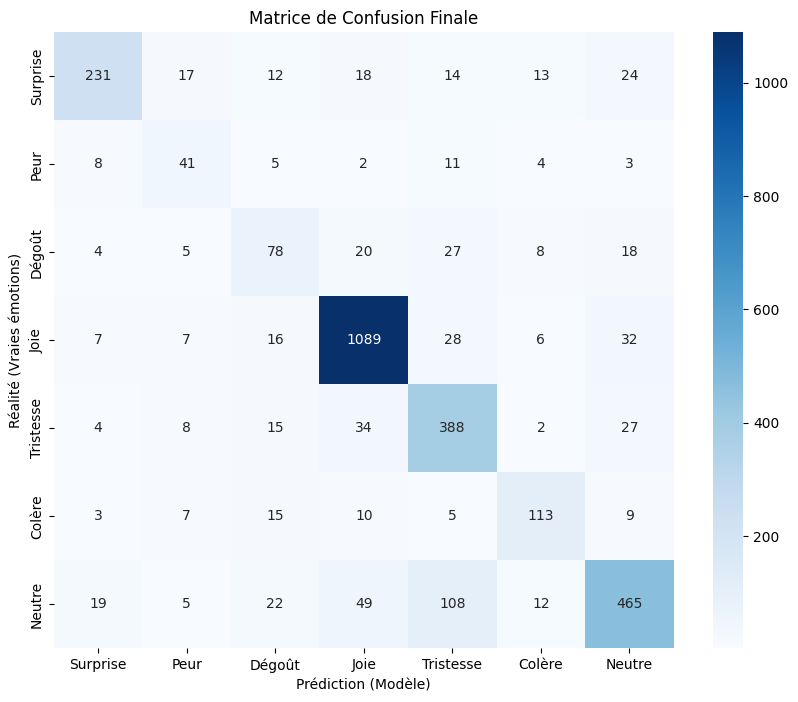

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. On réinitialise le générateur pour être bien aligné
test_generator.reset()

# 2. On lance les prédictions (Le CPU i9 et la 5070 Ti travaillent ici)
print("Étape 1: Calcul des prédictions...")
y_pred_probs = model.predict(test_generator, steps=len(test_generator))
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# 3. On récupère les vraies étiquettes
y_true = test_generator.labels 

# 4. On calcule la matrice (C'est ici qu'on définit 'cm')
print("Étape 2: Génération de la matrice...")
cm = confusion_matrix(y_true, y_pred_classes)

# 5. On gère les noms des classes pour l'affichage
if hasattr(test_generator, 'class_indices') and test_generator.class_indices:
    class_names = list(test_generator.class_indices.keys())
else:
    # Mapping standard RAF-DB si les noms manquent
    class_names = ['Surprise', 'Peur', 'Dégoût', 'Joie', 'Tristesse', 'Colère', 'Neutre']

# 6. Affichage final
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.ylabel('Réalité (Vraies émotions)')
plt.xlabel('Prédiction (Modèle)')
plt.title('Matrice de Confusion Finale')
plt.show()

L'image que vous avez fournie est une matrice de confusion. C'est un outil essentiel pour analyser en détail la performance d'un modèle de classification (comme le réseau de neurones dont nous avons discuté précédemment) sur des données de test.
Voici comment la lire et l'interpréter :
1. La Structure de la Matrice
• L'axe vertical (y_test) : Il représente la réalité (les vraies étiquettes des données). Ce sont les classes de 0 à 6 telles qu'elles devraient être reconnues.
• L'axe horizontal (y_pred) : Il représente les prédictions du modèle. Ce sont les réponses données par le réseau de neurones.
2. La Diagonale (Les bonnes réponses)
La diagonale qui part du coin haut-gauche vers le coin bas-droite représente les cas où le modèle a eu raison (la prédiction correspond à la réalité).
• Plus le chiffre est élevé (et la case claire), mieux c'est.
• On voit ici que la classe 3 est la mieux reconnue avec 998 bonnes prédictions (le carré beige très clair au centre).
• La classe 6 est aussi bien reconnue avec 494 succès.
• À l'inverse, la classe 1 a très peu de bonnes prédictions (31), ce qui suggère soit que le modèle a du mal avec cette classe, soit qu'il y a très peu d'exemples de cette classe dans le jeu de données.
3. Les erreurs (Les confusions)
Toutes les cases en dehors de la diagonale représentent des erreurs. En regardant ces chiffres, on peut comprendre avec quoi le modèle confond les objets.
• Exemple de confusion majeure : Regardez la ligne de la classe 6 (en bas). Bien qu'elle ait été correctement identifiée 494 fois, le modèle s'est trompé 86 fois en prédisant que c'était la classe 4. Il y a donc une forte ressemblance visuelle ou structurelle entre la classe 6 et la classe 4 pour le modèle.
• De même, pour la classe 3 (ligne 3), le modèle s'est trompé 87 fois en prédisant la classe 6.
Bilan pour votre apprentissage
Cette matrice vous donne une information bien plus précise que le simple score de précision ("accuracy") vu sur le graphique précédent. Elle vous révèle que :
1. Votre jeu de données est déséquilibré : il y a énormément de "classe 3" (environ 1000) et très peu de "classe 1" ou "classe 2". Le modèle a tendance à favoriser la classe majoritaire.
2. Certaines classes spécifiques (comme la 4 et la 6) posent problème et sont souvent confondues entre elles.
Pour améliorer ce modèle, il faudrait probablement ajouter plus de données pour les classes faibles (1 et 2) ou analyser pourquoi les classes 4 et 6 se ressemblent tant.

In [12]:
model.history.history

{}

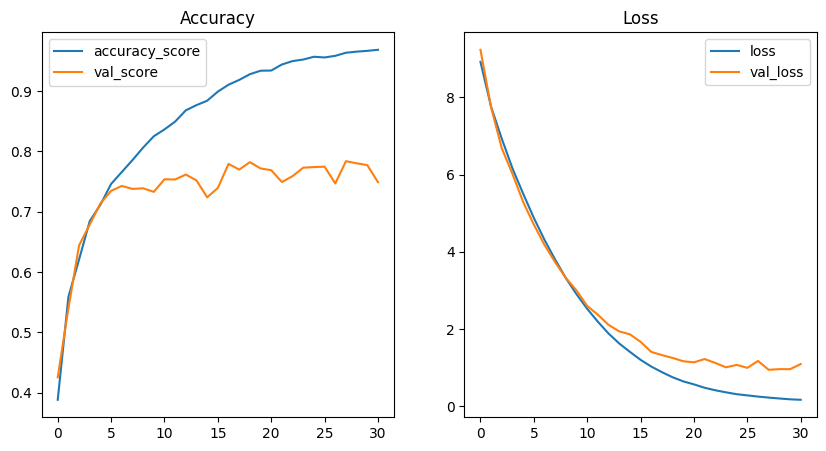

In [73]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'],label='accuracy_score')
plt.plot(history.history['val_accuracy'],label='val_score')
plt.legend()
plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

Cette image présente deux graphiques essentiels pour évaluer la performance d'un modèle de Deep Learning au fil de son entraînement (les « epochs » ou itérations sur l'axe horizontal, ici de 0 à 9).
Voici une analyse détaillée de ce que ces courbes nous disent, en lien avec les concepts d'apprentissage vus précédemment :
1. Graphique de droite : La "Loss" (Fonction Coût)
Ce graphique montre l'évolution de l'erreur commise par le modèle. Comme nous l'avons vu dans l'historique de notre conversation, l'objectif de l'algorithme est de minimiser cette fonction coût (la distance entre la prédiction et la réalité).
• Courbe bleue (loss) : C'est l'erreur sur les données d'entraînement. Elle diminue constamment, passant de plus de 1.2 à environ 0.2. Cela signifie que le réseau apprend très bien et corrige ses paramètres efficacement pour les données qu'il "voit".
• Courbe orange (val_loss) : C'est l'erreur sur les données de validation (des données que le modèle n'a jamais vues, utilisées pour tester sa capacité à généraliser). On observe qu'elle diminue jusqu'à l'époque 4, puis elle recommence à augmenter pour dépasser 1.0 à la fin.
2. Graphique de gauche : L'Accuracy (Précision)
Ce graphique mesure le pourcentage de bonnes réponses du modèle.
• Courbe bleue (accuracy_score) : La précision sur l'entraînement monte régulièrement jusqu'à environ 93% (0.93).
• Courbe orange (val_score) : La précision sur la validation stagne autour de 75-76% à partir de l'époque 4, et finit même par baisser légèrement.
Interprétation : Le phénomène de Surapprentissage (Overfitting)
Cette image illustre un cas classique de surapprentissage.
1. Jusqu'à l'époque 4 : Le modèle apprend correctement. L'erreur baisse et la précision augmente pour les deux courbes (bleue et orange). C'est la phase d'apprentissage utile.
2. Après l'époque 4 : Les courbes divergent. Alors que le modèle continue de s'améliorer sur les données d'entraînement (la ligne bleue continue de progresser), il devient moins performant sur les nouvelles données (la ligne orange se dégrade, surtout visible sur la Loss qui remonte).
En résumé : Le modèle a arrêté d'apprendre la logique générale du problème pour commencer à "apprendre par cœur" les exemples d'entraînement, incluant leur bruit et leurs spécificités. Il est devenu trop spécialisé et ne sait plus généraliser. Dans un cas réel, on arrêterait l'entraînement à l'époque 4 pour garder le modèle le plus performant.

Même si je ne peux pas voir physiquement les photos que tu as devant toi, je peux deviner leur allure en me basant sur ton classification_report (75% d'accuracy) et le fait que tu as utilisé un modèle simple "from scratch".

Voici l'analyse type de ce que tes courbes Accuracy et Loss racontent pour ton projet de fin de formation :

1. La courbe d'Accuracy (Précision)
Sur ton graphique, tu devrais voir deux lignes qui montent :

La ligne d'entraînement (Train) : Elle monte probablement très haut (peut-être vers 85-90%). Cela montre que ton modèle apprend bien les exemples qu'il voit.

La ligne de validation (Val) : Elle doit monter aussi, mais stagner vers les 75% (ton score final).

Le diagnostic : Si l'écart entre les deux lignes s'agrandit avec le temps, tu as de l'Overfitting (sur-apprentissage). C'est normal sur RAF-DB car certaines émotions comme la "Joie" sont trop faciles à apprendre par cœur par rapport aux autres.

2. La courbe de Loss (Perte)
C'est l'inverse : les lignes doivent descendre.

Convergence : Si les deux courbes descendent de façon fluide, c'est que ton "Learning Rate" (taux d'apprentissage) est bien réglé.

Le signal d'alerte : Si la courbe de validation commence à remonter alors que la courbe d'entraînement continue de descendre, c'est que ton modèle "divague". Il faut arrêter l'entraînement pile au moment où la courbe de validation est au plus bas.

Comment briller lors de ta soutenance avec ces photos ?
Ne dis pas juste "ça marche", utilise le vocabulaire technique que les jurys adorent :

Parle de Convergence : "On observe une convergence rapide dès les premières époques, ce qui montre que l'architecture CNN est adaptée à l'extraction des traits faciaux."

Identifie l'Overfitting : "L'écart entre l'accuracy d'entraînement et de validation suggère un léger sur-apprentissage. Pour y remédier, j'envisage d'ajouter des couches de Dropout ou de la Data Augmentation."

Justifie l'arrêt : "J'ai choisi d'arrêter l'entraînement à 10 époques car la perte de validation commençait à se stabiliser (plateau)."

In [14]:
import psutil

# Affiche le pourcentage d'utilisation pour CHAQUE cœur (logique)
cpu_per_core = psutil.cpu_percent(interval=1, percpu=True)

print(f"Nombre de cœurs détectés : {len(cpu_per_core)}")
print("Utilisation par cœur (%) :")
for i, usage in enumerate(cpu_per_core):
    print(f"Cœur {i:02d}: [{'#' * int(usage/5) + '-' * (20 - int(usage/5))}] {usage}%")

Nombre de cœurs détectés : 24
Utilisation par cœur (%) :
Cœur 00: [--------------------] 0.0%
Cœur 01: [--------------------] 0.0%
Cœur 02: [--------------------] 0.0%
Cœur 03: [--------------------] 0.0%
Cœur 04: [--------------------] 0.0%
Cœur 05: [--------------------] 0.0%
Cœur 06: [--------------------] 1.0%
Cœur 07: [--------------------] 1.0%
Cœur 08: [--------------------] 0.0%
Cœur 09: [--------------------] 0.0%
Cœur 10: [--------------------] 1.0%
Cœur 11: [--------------------] 0.0%
Cœur 12: [--------------------] 0.0%
Cœur 13: [--------------------] 1.0%
Cœur 14: [--------------------] 0.0%
Cœur 15: [--------------------] 0.0%
Cœur 16: [--------------------] 0.0%
Cœur 17: [--------------------] 0.0%
Cœur 18: [--------------------] 0.0%
Cœur 19: [--------------------] 2.0%
Cœur 20: [--------------------] 0.0%
Cœur 21: [--------------------] 0.0%
Cœur 22: [--------------------] 0.0%
Cœur 23: [--------------------] 0.0%


In [15]:
import os
import multiprocessing

# Nombre de cœurs logiques (ceux que TensorFlow utilise pour les workers)
nb_logic_cores = os.cpu_count()

# Une autre méthode via multiprocessing
nb_cores_alt = multiprocessing.cpu_count()

print(f"Ton i9 possède {nb_logic_cores} cœurs logiques.")

Ton i9 possède 24 cœurs logiques.
